In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import subprocess
import pandas as pd
import numpy as np
from os import listdir
import wave

# location of wave files and text files, also the location to save the CSVs
loc = '.../' 

In [2]:
def parse_textgrid(story, phonemes="False"):
    """Returns a DataFrame with the xmin and xmax for the words or phonemes"""
    
    story = story.split('KAN')[0] if not phonemes else story.split('MAU')[1]
    xmin = [line.split(' ')[-1] for line in story.split('\n') if 'xmin' in line and "<p:>" not in line]
    xmax = [line.split(' ')[-1] for line in story.split('\n') if 'xmax' in line and "<p:>" not in line]
    words = [line.split(' ')[-1].replace('"', '') for line in story.split('\n') if 'text' in line and "<p:>" not in line]

    df = pd.DataFrame()
    df["xmin"] = [float(x) for x in xmin[3:-1]]
    df["xmax"] = [float(x) for x in xmax[3:-1]]
    df["word" if not phonemes else "phoneme"] = (words[1:-1] if not phonemes else words[:-1])
    
    return df

def get_textgrid(textfile, wavfile, phonemes=False):
    """Use CurlCall to feed the wave and text file into MAUS and passes it through the parse_textgrid function. 
    Returns the Dataframe with relevant time information"""
    
    curlcall = "curl  -X POST -H 'content-type: multipart/form-data'  -F OUTFORMAT=TextGrid -F NOINITIALFINALSILENCE=false -F INSKANTEXTGRID=true -F TEXT=@'{}' -F INSORTTEXTGRID=true -F SIGNAL=@'{}' 'https://clarin.phonetik.uni-muenchen.de/BASWebServices/services/runMAUSBasic'".format(*(textfile, wavfile))
    result = subprocess.check_output(curlcall, shell=True)
    url = str(result).split("<")[4].split(">")[1]
 
    targetfile = 'targetfile' # an empty targetfile is required, you can use the one on my github page
    curlcall2 = 'curl ' + url + ' > ' + targetfile
    subprocess.call(curlcall2, shell=True)

    with open(targetfile) as f:
        textgrid = parse_textgrid(f.read(), phonemes=phonemes)
    
    return textgrid


In [3]:
files = [file for file in listdir() if ".wav" in file] # creates a list of the wav files
len(files), files[0]

(275, '1.wav')

In [4]:
# Parse words in audio file based on transcipts (txt files for respective wav file)
for wav in files:
    textfile = loc+wav.replace(".wav", ".txt") # loads the relevant text file
    df = get_textgrid(textfile, loc+wav) # creates the DataFrame
    df.to_csv(loc+wav.replace(".wav", ".csv")) # saves the csv file into the same location as the wavs and txts
    

In [5]:
# Example of word onsets and offsets
df

,xmin,xmax,word
0,0.85,1.03,Seit
1,1.03,1.58,gestern
2,1.58,1.74,geht
3,1.74,1.84,es
4,1.84,2.01,dem
5,2.01,2.82,Patienten
6,2.82,3.28,deutlich
7,3.28,3.82,besser


In [6]:
# Same as before but now we parse the phonemes
for wav in files:
    textfile = loc+wav.replace(".wav", ".txt")
    df = get_textgrid(textfile, loc+wav, phonemes=True)
    df.to_csv(loc+wav.replace(".wav", ".csv"))
    

In [7]:
# Example of phoneme DataFrame
df

,xmin,xmax,phoneme
0,0.89,1.00,z
1,1.00,1.03,aI
2,1.03,1.11,t
3,1.11,1.21,g
4,1.21,1.29,E
5,1.29,1.35,s
6,1.35,1.58,t
7,1.58,1.62,6
8,1.62,1.70,g
9,1.70,1.74,e:


In [8]:
wav_signal = wave.open(loc+wav).readframes(-1)
signal = np.fromstring(wav_signal, 'Int16')

dfs = pd.DataFrame()
time, sig = [], []
for ii, m in enumerate(signal):
    time.append(ii/44100), sig.append(m)
dfs["Time"] = time
dfs["Signal"] = sig

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


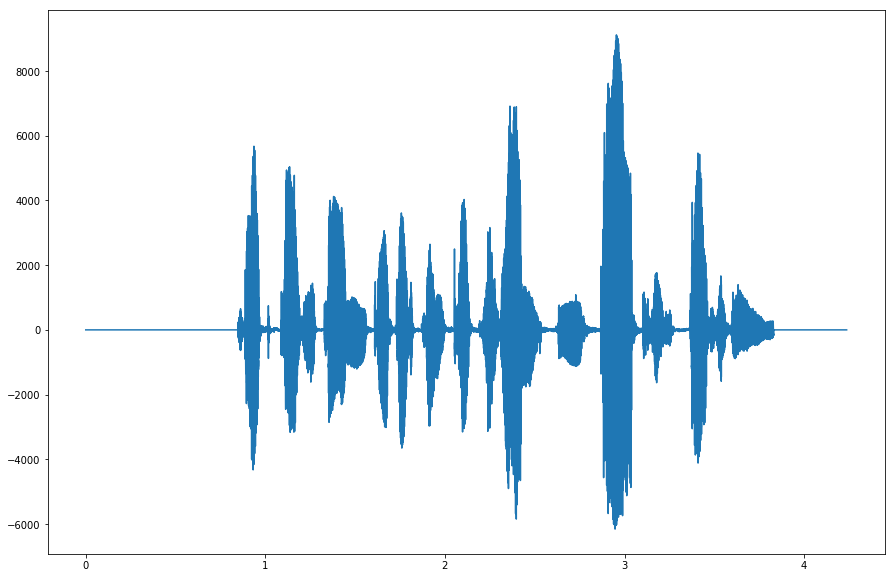

In [9]:
# Plotted audio signal
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 10)
ax.plot(dfs.Time, dfs.Signal)